# Машинное обучение, ФКН ВШЭ

# Семинар 7

## Критерий останова построения дерева

Для любой непротиворечивой обучающей выборки можно построить решающее дерево, которое имеет нулевую ошибку на данной выборке. Если мы рассмотрим объекты, как точки в пространстве признаков, то каждую эту точку можно ограничить n-мерным кубиком, который не будет содержать других точек. n-мерный кубик прекрасно можно задать деревом.

 Однако в этом случае имеет место **переобучение**. 

В связи с этим встаёт вопрос: в каком случае вершину следует объявить листовой?

Рассмотрим модельную задачу регрессии. Объектами будут являться точки на плоскости (т.е. каждый объект описывается 2 признаками), целевой переменной — расстояние от объекта до точки (0, 0).

In [10]:
%pylab inline
import numpy as np
import pandas as pd
import pylab as plt
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set(style='whitegrid')

Populating the interactive namespace from numpy and matplotlib


In [11]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

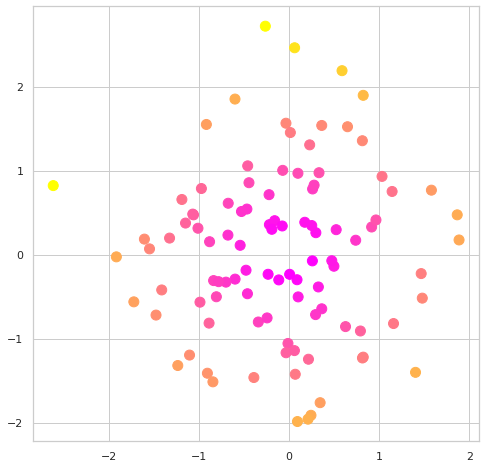

In [12]:
np.random.seed(42)
data_x = np.random.normal(size=(100, 2))
data_y = (data_x[:, 0] ** 2 + data_x[:, 1] ** 2) ** 0.5 # 
plt.figure(figsize=(8, 8))
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring')

In [13]:
from sklearn.tree import DecisionTreeRegressor

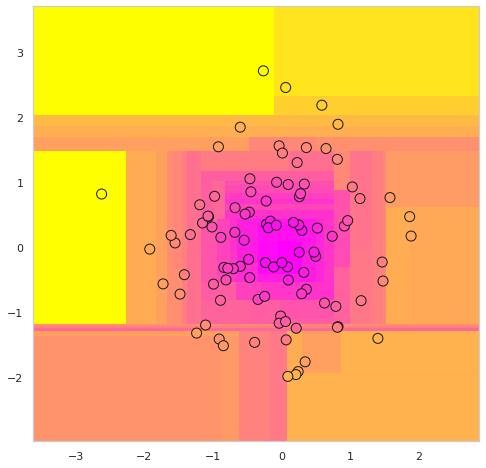

In [14]:
clf = DecisionTreeRegressor(random_state=42)
clf.fit(data_x, data_y)

xx, yy = get_grid(data_x)

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, predicted, cmap='spring')
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring', edgecolor='k')

Посмотрим как будет выглядить разделение плоскости в зависимости от 
- минимального количества объектов в листе
- максимальной глубины дерева

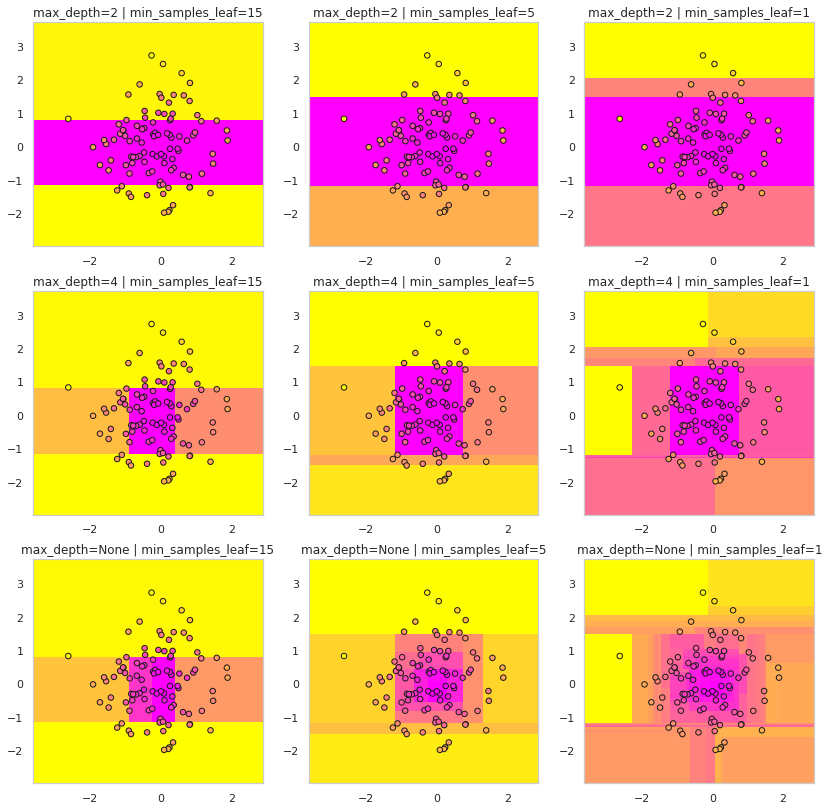

In [15]:
plt.figure(figsize=(14, 14))
for i, max_depth in enumerate([2, 4, None]):
    for j, min_samples_leaf in enumerate([15, 5, 1]):
        clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        clf.fit(data_x, data_y)
        xx, yy = get_grid(data_x)
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
        plt.subplot2grid((3, 3), (i, j))
        plt.pcolormesh(xx, yy, predicted, cmap='spring')
        plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='spring', edgecolor='k')
        plt.title('max_depth=' + str(max_depth) + ' | min_samples_leaf=' + str(min_samples_leaf))

- Увеличение максимальной глубины и/или уменьшение минимального количества объектов выборки в листе приводит к увеличению качества на обучающей выборке и переобучению.

## Неустойчивость решающих деревьев

Решающие деревья — это алгоритмы, неустойчивые к изменениям обучающей выборки, т.е. при малейших её изменениях итоговый классификатор может радикально измениться.
Посмотрим, как будет меняться структура дерева при обучении на разных 90%-х подвыборках.


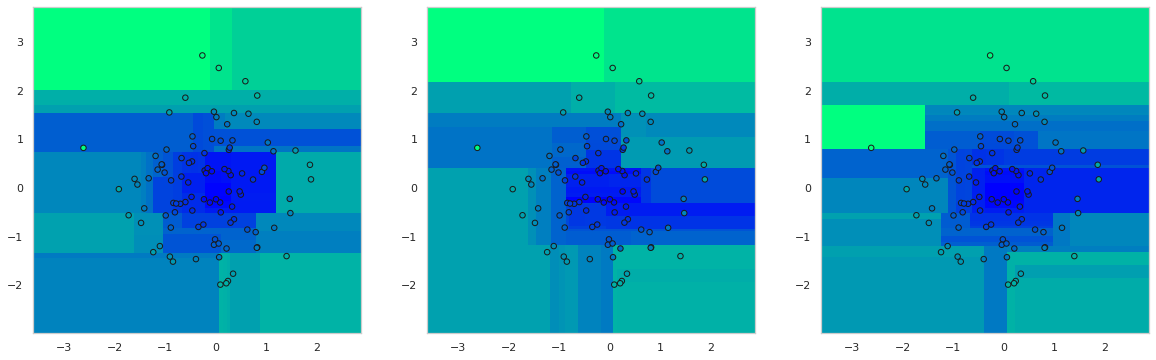

In [16]:
plt.figure(figsize=(20, 6))
for i in range(3):
    clf = DecisionTreeRegressor(random_state=42)

    indecies = np.random.randint(data_x.shape[0], size=int(data_x.shape[0] * 0.9))
    clf.fit(data_x[indecies], data_y[indecies])
    xx, yy = get_grid(data_x)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot2grid((1, 3), (0, i))
    plt.pcolormesh(xx, yy, predicted, cmap='winter')
    plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='winter', edgecolor='k')

## Подбор параметров

Посмотрим на качество дерева в зависимости от параметров на одном из стандартных наборов данных &mdash; Бостонском датасете.

Загрузим датасет и посмотрим на него.

In [17]:
from sklearn.datasets import load_boston

data = load_boston()
X = data.data
y = data.target

Сделаем разбиения для кросс-валидации

In [18]:
from sklearn.model_selection import KFold, cross_val_score
cv = KFold(shuffle=True, random_state=241)

Обучим обычное дерево

In [19]:
from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor(random_state=241)
-cross_val_score(regr, X, y, cv=cv, 
                 scoring='neg_mean_squared_error').mean()

29.252426713259563

In [29]:
np.square((y-y.mean())).mean()

84.41955615616556

In [20]:
regr.fit(X, y)
regr.tree_

In [21]:
from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor(random_state=241)
cross_val_score(regr, X, y, cv=cv, 
                scoring='r2').mean()

0.63896748450608

Теперь переберем разные параметры для дерева

In [36]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(DecisionTreeRegressor(random_state=241),
                  param_grid={
                      'max_features': ['auto', 'log2', 'sqrt'], # the number of features to consider when looking for the best split
                      'max_depth': [2, 4, 6, 8, 10, 20, 50],
                      'min_samples_leaf': [1, 4, 8, 32],
                  },
                  cv=cv,
                  scoring='r2')
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=241, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=241),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 20, 50],
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'min_samples_leaf': [1, 4, 8, 32]},
             scoring='r2')

In [37]:
cv_grid = pd.DataFrame(gs.cv_results_['params'])

cv_grid['mean_test_score'] = gs.cv_results_['mean_test_score']

In [41]:
cv_grid.sort*?

cv_grid.sort_index
cv_grid.sort_values

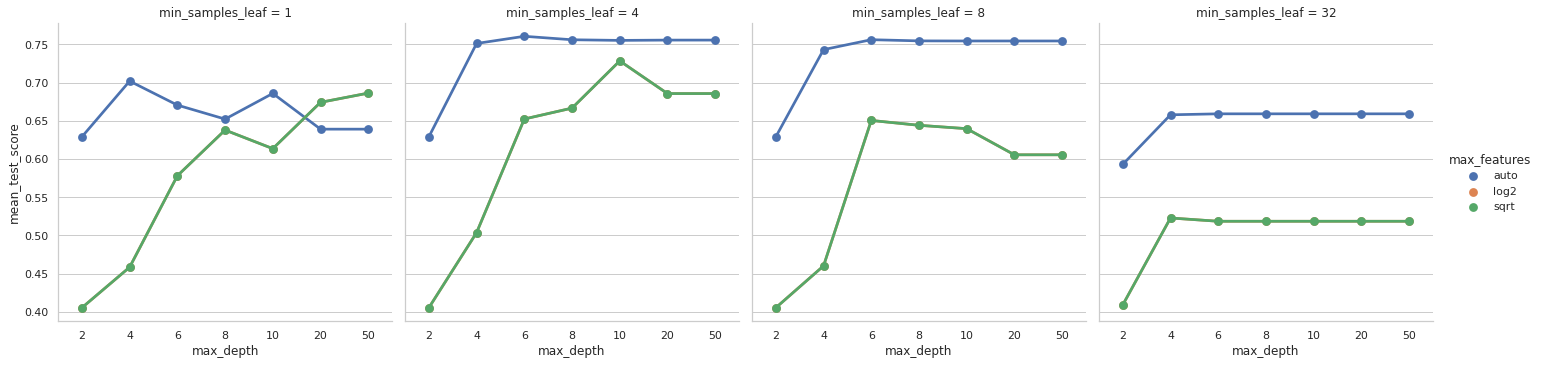

In [42]:
sns.catplot(x='max_depth', y='mean_test_score', data=cv_grid,
            col='min_samples_leaf', hue='max_features',
            kind='point')

* предположите почему при увеличении параметра `min_samples_leaf` дерево перестает переобучаться при росте `max_depth` ?

In [43]:
gs.best_score_

0.7604838117717478

In [44]:
gs.best_params_

{'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 4}